# Hyperparameter Tuning for Losistic Regrssion Classifier
**Prepared by:** Adisorn Promkaewngarm

# Import Library

In [1]:
!pip -q install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mplfinance as mpf
from sklearn.linear_model import LogisticRegression
import time
import numpy as np
import time
from google.colab import output


# Import Data

In [3]:
# GitHub Raw Data Paths
path_feature = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_SET_features_weekly.csv'
path_label_train = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_regime_labeling_traindata_weekly.csv'
path_set_data = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/SET_Index_Weekly_2010_2025.csv'

# 1. Load the feature set
df_features = pd.read_csv(path_feature, index_col=0, parse_dates=True)

  # Train-Test split by period
df_features_train = df_features.loc[df_features.index.year < 2023].copy()
df_features_train = df_features_train.iloc[:, 1:] # Remove currnet return

  # Train-Test split by period
df_features_test = df_features.loc[df_features.index.year >= 2023,].copy()
df_features_test = df_features_test.iloc[:, 1:] # Remove currnet return

# 2. Load the training labels
df_labels = pd.read_csv(path_label_train, index_col=0, parse_dates=True)
df_labels_train = df_labels['Regime_ID'].copy()

# 3. Load the raw SET Index OHLC data
df_set_index = pd.read_csv(path_set_data, index_col=0, parse_dates=True)

# Data Normalization

In [4]:
# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit and Transform the Training Data
X_train_scaled = scaler.fit_transform(df_features_train)

# 3. Transform the Testing Data (using the training parameters)
X_test_scaled = scaler.transform(df_features_test)

# Convert back to DataFrame to maintain column names for XGBoost
X_train_final = pd.DataFrame(X_train_scaled, index=df_features_train.index, columns=df_features_train.columns)
X_test_final = pd.DataFrame(X_test_scaled, index=df_features_test.index, columns=df_features_test.columns)

In [5]:
from sklearn.decomposition import PCA

# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit and Transform the Training Data
X_train_scaled = scaler.fit_transform(df_features_train)

# 3. Transform the Testing Data
X_test_scaled = scaler.transform(df_features_test)

# --- PCA STEP ---

# 4. Initialize PCA
pca = PCA(n_components=0.9)

# 5. Fit PCA on scaled training data and transform both
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 6. Convert to DataFrames (Replacing original features)
pc_columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]

X_train_final = pd.DataFrame(X_train_pca, index=df_features_train.index, columns=pc_columns)
X_test_final = pd.DataFrame(X_test_pca, index=df_features_test.index, columns=pc_columns)

# Hyperparameter Tuning

In [6]:
# Set to True to run hyperparameter tuning
run_tuning_lr = False

if run_tuning_lr:
    # Setup Model
    # We use 'multinomial' for your 3 regimes (Bull, Sideways, Bear)
    lr_clf = LogisticRegression(
        multi_class='multinomial',
        random_state=42,
        max_iter=1000 # Increased to ensure convergence with many features
    )

    # Parameter Distribution for Logistic Regression
    param_dist_lr = {
        'C': np.logspace(-4, 4, 20), # Regularization strength (Inverse: smaller is stronger)
        'penalty': ['l1', 'l2'],      # Lasso (L1) or Ridge (L2) regularization
        'solver': ['saga'],           # 'saga' supports both l1 and l2 and is fast for large datasets
        'class_weight': ['balanced'] # Handles potential regime imbalances
    }

    # Execution with TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Testing 50 random combinations (250 total fits)
    # Logistic Regression is faster than XGBoost, so 50-100 iterations is usually plenty
    random_search_lr = RandomizedSearchCV(
        estimator=lr_clf,
        param_distributions=param_dist_lr,
        n_iter=50,
        cv=tscv,
        scoring='f1_macro',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    start_time = time.time()
    random_search_lr.fit(X_train_final, df_labels_train)
    duration = time.time() - start_time

    # Audio notification for Google Colab
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

    # Results
    print("\n" + "="*50)
    print(f"LOGISTIC REGRESSION SEARCH COMPLETED")
    print(f"Total Time Spent:  {duration:.2f} seconds")
    print("-" * 50)
    print(f"Best Parameters:   {random_search_lr.best_params_}")
    print(f"Best CV Accuracy:  {random_search_lr.best_score_:.4f}")
    print("="*50)

    # Assign the best model
    best_lr_model = random_search_lr.best_estimator_
else:
    print("Skipping tuning: Using previously defined best_lr_model.")

Fitting 5 folds for each of 40 candidates, totalling 200 fits

LOGISTIC REGRESSION SEARCH COMPLETED
Total Time Spent:  7.07 seconds
--------------------------------------------------
Best Parameters:   {'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced', 'C': np.float64(0.08858667904100823)}
Best CV Accuracy:  0.4152


Baed on accuracy

Best Parameters:  

 {'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced', 'C': np.float64(0.004832930238571752)}

Best CV Accuracy:  0.4769

# Model training

In [7]:
# Initialize the final Logistic Regression model with your optimized parameters
final_lr_model = LogisticRegression(
    C=0.08858667904100823,
    penalty='l1',
    class_weight='balanced',
    solver='saga',
    multi_class='multinomial',
    random_state=42,
    max_iter=2000
)

# Fit the model using the training data and labels (2011-2022)
final_lr_model.fit(X_train_final, df_labels_train)

print("Final Logistic Regression model fitted on the full training set.")

Final Logistic Regression model fitted on the full training set.


In [8]:
# 1. Predict for the Training Set (In-Sample: 2011-2022)
y_train_pred_lr = final_lr_model.predict(X_train_final)
y_train_prob_lr = final_lr_model.predict_proba(X_train_final)

# 2. Predict for the Test Set (Out-of-Sample: 2023-2025)
y_test_pred_lr = final_lr_model.predict(X_test_final)
y_test_prob_lr = final_lr_model.predict_proba(X_test_final)

# 3. Quick Check of Prediction Distribution
import pandas as pd
print("="*40)
print("LOGISTIC REGRESSION: TEST SET REGIMES")
print("="*40)
distribution = pd.Series(y_test_pred_lr).value_counts().sort_index()
print(distribution)

# Mapping for clarity
regime_names = {0: 'Bull', 1: 'Sideways', 2: 'Bear'}
print("\nReadable Distribution:")
for regime_id, count in distribution.items():
    print(f"{regime_names.get(regime_id, 'Unknown')}: {count} weeks")

LOGISTIC REGRESSION: TEST SET REGIMES
0    102
1     28
2     27
Name: count, dtype: int64

Readable Distribution:
Bull: 102 weeks
Sideways: 28 weeks
Bear: 27 weeks


LOGISTIC REGRESSION: TRAINING SET PERFORMANCE (2011-2022)
                     precision    recall  f1-score   support

    Regime 0 (Bull)       0.59      0.69      0.64       249
Regime 1 (Sideways)       0.45      0.34      0.39       201
    Regime 2 (Bear)       0.57      0.59      0.58       176

           accuracy                           0.55       626
          macro avg       0.54      0.54      0.53       626
       weighted avg       0.54      0.55      0.54       626



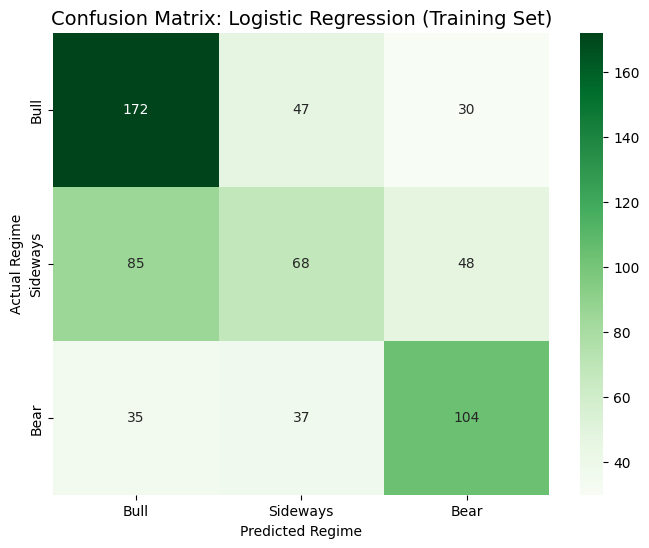

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Classification Report for Training Data (Logistic Regression)
print("="*60)
print("LOGISTIC REGRESSION: TRAINING SET PERFORMANCE (2011-2022)")
print("="*60)

# Defining labels for the report
target_names = ['Regime 0 (Bull)', 'Regime 1 (Sideways)', 'Regime 2 (Bear)']
print(classification_report(df_labels_train, y_train_pred_lr, target_names=target_names))

# 2. Confusion Matrix for Training Data
cm_train_lr = confusion_matrix(df_labels_train, y_train_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_train_lr,
    annot=True,
    fmt='d',
    cmap='Greens', # Different color to distinguish from XGBoost
    xticklabels=['Bull', 'Sideways', 'Bear'],
    yticklabels=['Bull', 'Sideways', 'Bear']
)

plt.title('Confusion Matrix: Logistic Regression (Training Set)', fontsize=14)
plt.xlabel('Predicted Regime')
plt.ylabel('Actual Regime')
plt.show()